**Note:** as this was a previous point in the project, some definitions and statements may not be accurate, or may have changed later.   
Make sure to refer to the files labeled as `ME536_Project_v4` for the latest changes.

#To-Do List
Track progress of the project here.

##Completed Things
- **Image Processing** - ~Prepare a feature class~ 
  - ~Load RegionProps into instances as attributes~
  - ~Load the zero-background feature snapshots as an attribute~
  - ~Load the label of region as an attribute~ 

- **Image Processing** - ~Prepare a function (or method of feature class)~
  - ~Iteratively go through all labeled regions~  
  - ~Generate feature attributes~  

- **Image Processing** -   
  _Optional_: Prepare live cam feed  
  _Minimum req._: Prepare to take photos from cam feed on demand
  - Option 1: Take photos at intervals (once every few seconds)
  - Option 2: Capture live video, but process it at intervals
  - Option 3: Capture live video and process it live(?) (maybe at a specified fps)  

  *Maybe set up camera feed on a Colab Notebook to do it on Colab*

- **Data Analysis**, **Clustering** - Prepare "chord" generation (clustering), and sound effect selection (line fitting)
  - **Data Analysis** - ~Review SVD, CUR, PCA as required~
  - ~Define 4 principal axes (vertical, horizontal, left diagonal, right diagonal)~
  - **Data Analysis** - ~Try fitting appropriate axes for objects in given orientations~
  - **Data Clustering** - ~**Option 2:** Maybe use a clustering algorithm like KMeans for centroid clustering~

- **Calibrations, Interactive Objects**
  - Print papier-mache/cardboard objects
  - Calibrate filtering
  - Calibrate bounding boxes for different objects
  - Calibrate maximum centroid distances for clustering

- **Artificial Neural Networks**

- **Miscellaneous** - only if time allows it
  - Sound output correlations for prepared cluster labelling and line fitting outputs (req. Data Clustering and Analysis)
  - Random sound assignments for "new" features (req. ANN)


#Imports and Image/Video Input

In [ ]:
# Core imports

#Image processing -- may use one or both
import skimage
#import cv2
#Python image library is convenient to open images
#from PIL import Image, ImageDraw, ImageFont

#Handling data
import numpy as np
#import scipy
from scipy import ndimage as ndi

#Imports from skimage
from skimage import measure
from skimage import filters
from skimage import morphology
from skimage import io
from skimage.color import rgb2gray
#from skimage.color import gray2rgb
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

#Imports from sklearn for data clustering
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#VARIABLES FOR FUNCTION CALIBRATION
bound_ratio = 4 #use when calling FeatureExtractor
tolerance = 275 #use to calibrate clustering 
n_iterations = 3 #number of times the clustering is iterated

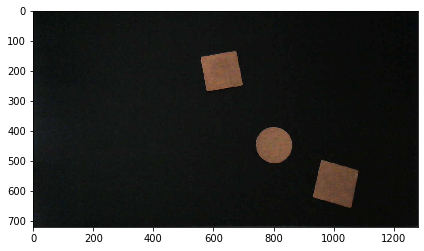

In [ ]:
#Using this tutorial > https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_labels.html
#!ls "/content/gdrive/MyDrive"
#Mount drive, and read file -- has to be replaced with a camera feed later
test_image = io.imread("/content/gdrive/MyDrive/webcam_test.jpg")
io.imshow(test_image)

#Executing the entire block through a test image
No neural networks or clustering yet, but it's the next step!

In [ ]:
#Obtain an image in this block
"""
A good idea could be pressing a button to continue feeding images, in a while loop?
"""
im = test_image.copy()

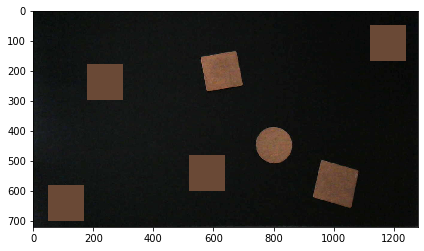

In [ ]:
#From the playground for feature clustering
#Generating a test image for clustering demos

#io.imshow(test_image)
#Using the binary image from the feature extraction playground
#io.imshow(fill_objects)
im_cluster= im.copy()

#Adding in 4 more squares to play with
im_cluster[180:300,180:300] = [106.5400915,73.5848784,54.51492897]
im_cluster[480:600,520:640] = [106.5400915,73.5848784,54.51492897]
im_cluster[50:170,1120:1240] = [106.5400915,73.5848784,54.51492897]
im_cluster[580:700,50:170] = [106.5400915,73.5848784,54.51492897]
io.imshow(im_cluster)

In [ ]:
#First extract the features
features_extracted = FeatureExtractor(im_cluster)

#At this point, the function to carry out the neural network will run:
#features_nn = FeatureNN(features_extracted)

#Then cluster the features
features_clustered = FeatureGeoClustering(features_extracted)
#Then assign the id of the closest diagonal, vertical or horizontal line
#to the line fitted through the feature centroids
features = FeatureLineFitting(features_clustered)

In [ ]:
#See results:
for feature in features:
  print(feature)

Feature Number: 1,
        Averaged RGB values of feature: [[106.  73.  54.]],
        Centroid: (109.5, 1179.5),
        Perimeter: 473.65685424949237,
        Area: 14396,
        Orientation [Radians]: 0.7853981633974483,
        Euler Number: 1,
        Compactness: 1.2401549488004056,
        Top Left Corner: (0, 1057),
        Bottom Right Corner: (230, 1280),
        Cluster: -1,
        Assigned Effect #ID: None,
        Feature Vector: None
Feature Number: 2,
        Averaged RGB values of feature: [[135.08620811  93.06217944  69.34138973]],
        Centroid: (202.46778613082273, 626.4627977236),
        Perimeter: 492.69343417595167,
        Area: 14233,
        Orientation [Radians]: 1.5037918374767683,
        Euler Number: 1,
        Compactness: 1.357210578781203,
        Top Left Corner: (86, 510),
        Bottom Right Corner: (317, 741),
        Cluster: -1,
        Assigned Effect #ID: None,
        Feature Vector: None
Feature Number: 3,
        Averaged RGB values of

#Function definition for feature extraction and the Feature class

Earlier on in the implementation, a *bound ratio* definition was created to get variably sized bounding frames for the images. This works perfectly well for convex and regular objects, which were the initial picks to work with. However, a fixed size frame is equally as good most of the time. If it is necessary to work with variable frame sizes due to differing object sizes, this approach could be used to an extent.  
See the cell block: [**Playground before function implementation**](https://colab.research.google.com/drive/1Q5-dEJPiiyRpgtX5Ht22JSKXQ3bRKjYK#scrollTo=tN1C7qDLL3Gm&line=2&uniqifier=1) for the explanation of how this works.

In [ ]:
class Feature: 
  """
  The Feature class, to hold features, and the associated object image 
  (and later on, audio) of the feature vector.
  Some attributes may be used as neural network hyperparameters.
  Some attributes are required to find others (passed as None).
  Generate a Feature by first processing an image through FeatureExtractor.

  Dependencies: from skimage import io
                import numpy as np

  Attributes: Read the docstring of FeatureExtractor for more details.
              
              flushed_image:  The color image of the object bounded in a box,
                              with the background removed.
              
              vector: Feature vector obtained by the neural network.
              
              cluster: Clustering label, used to group objects that are near.
              
              sound: Sound file assigned to the feature. This could be an index
              pointing to the list of sound files, loaded along with training
              data for the neural network. The sound files will have new entries
              if the neural network recognizes the object as "new".
              
              effect_id: Sound effect assigned by the data analysis functions 
              to the feature. Could be a filter, reverb, reverse, etc. 
              Applicable to chords.
              Chords are objects clustered by their centroid distances.

  Methods:    imshow(): calls io.imshow() to view the flushed image.
  """
  def __init__(self, index, color, centroid, perimeter, area, orientation, 
               euler_number, compactness, corner_topleft, corner_botright, 
               flushed_image, vector=None, cluster=None, effect_id=None, 
               sound=None):
    self.index = index
    self.color = color
    self.centroid = centroid
    self.perimeter = perimeter
    self.area = area
    self.orientation = orientation
    self.euler_number = euler_number
    self.compactness = compactness
    self.corner_topleft = corner_topleft
    self.corner_botright = corner_botright
    self.flushed_image = flushed_image
    self.vector = vector
    self.cluster = cluster
    self.effect_id = effect_id
    self.sound = sound

  def __str__(self):
    return (
        f'''Object Number: {self.index},
        Averaged RGB values of feature: {self.color},
        Centroid: {self.centroid},
        Perimeter: {self.perimeter},
        Area: {self.area},
        Orientation [Radians]: {self.orientation},
        Euler Number: {self.euler_number},
        Compactness: {self.compactness},
        Top Left Corner: {self.corner_topleft},
        Bottom Right Corner: {self.corner_botright},
        Cluster: {self.cluster},
        Assigned Effect #ID: {self.effect_id},
        Feature Vector: {self.vector}'''
        
    )
  
  def imshow(self):
    #Returns the feature's "flushed" image, i.e. with zero-background
    #https://github.com/scikit-image/scikit-image/blob/master/skimage/io/_io.py#L139-L159
    return io.imshow(self.flushed_image)

In [ ]:
def FeatureExtractor(image, bound_ratio = 4, visualize=False, debugMode=False):
  
  """
  Extract from an image, the features on the foreground of the image and their
  attributes. 
  Requires a Feature class to function. 

  Dependencies: import skimage
                import numpy as np
                import scipy.ndimage as ndi
                import skimage.morphology as morphology
                from skimage.filters import threshold_otsu
                from skimage import io
                from skimage import measure
                import matplotlib.pyplot as plt
                from skimage.color import rgb2gray

  Note:
  Can be also used on grayscale images without failure, but the original image
  will be then a grayscale one, when the isolated image is shown; and the color 
  values will be for the grayscale image.

  Inputs: numpy.ndarray (3D RGB image, or 2D grayscale image)
          
          bound_ratio (float): Defines how large the bounding window will be. Explicitly
          defines the ratio of the feature's area to its circumference.
          Recommended value is 4, and the minimum possible value is 3.6. Going
          lower may cause clipping.

          visualize (bool): True - enable plots for the feature extraction 
          process, to debug in case additional features appear due to 
          inadequate filtering. Defaults to False.

          debugMode (bool): True - Enable debug outputs. Defaults to False.

  Outputs:  feature_idx (list, int) - List of object label numbers

            colors (list, numpy.ndarray) - List of feature colors in RGB

            centroids (list, float) - List of object centroid positions 
            on original image.

            perimeters (list, float) - List of feature perimeters
            
            areas (list, float) - List of feature areas
            
            orientations (list, float) - List of feature orientations. 
            The CCW angle with the positive horizontal axis is given in radians.
            
            euler_numbers (list, float) - List of feature Euler Numbers 
            (8-neighbors).
            
            TL_corners (list, tuple, int) - List of feature top left corner
            index positions, on original image. 
            Useful for bounding box generation.
            
            BR_corners (list, tuple, int) - List of feature bottom right corner
            index positions, on original image. 
            Useful for bounding box generation.
  """

  #Load in the image, and get grayscale
  im = image.copy()
  gray = rgb2gray(im)

  #Binarization, using Otsu's thresholding method
  thresh = threshold_otsu(gray)
  binary = gray > thresh 
  
  #Salt and pepper noise is to be removed inside the objects

  fill_objects = binary.copy()
  #Using morphology operations to remove noise
  fill_objects = morphology.binary_erosion(fill_objects)
  fill_objects = ndi.binary_fill_holes(fill_objects)
  fill_objects = morphology.binary_closing(fill_objects)
  fill_objects = morphology.binary_dilation(fill_objects)
  
  labels = measure.label(fill_objects, background = 0)
  if debugMode == True:
    print(f"The number of features recognized:{labels.max()}") #should be equal to the number of objects on the picture

  #Using connected component labeling tools of skimage
  props = measure.regionprops(labels)
  
  features = []

  feature_idx = []
  colors = []
  centroids = []
  perimeters = []
  areas = []
  orientations = []
  euler_numbers = []
  compactnesses = []
  TL_corners = []
  BR_corners = []

  for label_pick in range(1,labels.max()+1):
    centroid = props[label_pick-1].centroid
    perimeter = props[label_pick-1].perimeter
    area = props[label_pick-1].area
    orientation = props[label_pick-1].orientation
    euler_number = props[label_pick-1].euler_number #8-neighbors
    compactness = (perimeter**2/area)/(4*np.pi) #defined in class

    #Get a trimmed off image
    feature = np.zeros_like(labels)
    #The "feature image" to be fed into the neural network
    #Delete the background
    feature = np.where((labels==label_pick),labels,0)
    trimmed = feature.copy()

    #initialize boundaries
    bound_top = 0
    bound_bot = feature.shape[0]
    bound_left = 0
    bound_right = feature.shape[1]

    #use bounded frames derived from centroid position, area, and perimeter data
    #quite effective in bounding anything at all - details in the formulation below
    bound = (area/perimeter)*bound_ratio
    center = tuple([int(centroid[0]),int(centroid[1])])

    if center[0]-bound > 0:
      bound_top = int(center[0]-bound)
    else:
      bound_top = 0

    if center[0]+bound < im.shape[0]:
      bound_bot = int(center[0]+bound)
    else:
      bound_bot = im.shape[0]

    if center[1]-bound > 0:
      bound_left = int(center[1]-bound)
    else:
      bound_left = 0

    if center[1]+bound < im.shape[1]:
      bound_right = int(center[1]+bound)
    else:
      bound_right = im.shape[1]

    trimmed = feature[bound_top:bound_bot,bound_left:bound_right]
    #plt.imshow(trimmed, cmap="nipy_spectral")

    im_trimmed = im[bound_top:bound_bot,bound_left:bound_right].copy()
    im_flushed = im_trimmed.copy()

    im_flushed[:,:,0] = np.where(trimmed==label_pick, im_trimmed[:,:,0], 0)
    im_flushed[:,:,1] = np.where(trimmed==label_pick, im_trimmed[:,:,1], 0)
    im_flushed[:,:,2] = np.where(trimmed==label_pick, im_trimmed[:,:,2], 0)

    feature_color = np.zeros((1,3))

    red_flushed = im_flushed[:,:,0]
    green_flushed = im_flushed[:,:,1]
    blue_flushed = im_flushed[:,:,2]

    feature_color[:,0] = red_flushed[red_flushed.nonzero()].mean()
    feature_color[:,1] = green_flushed[green_flushed.nonzero()].mean()
    feature_color[:,2] = blue_flushed[blue_flushed.nonzero()].mean()

    if debugMode == True:
      print(f"Feature Number: {label_pick}")
      print(f"Averaged RGB values of feature: {feature_color}")
      print(f"Centroid: {centroid}")
      print(f"Perimeter: {perimeter}")
      print(f"Area: {area}")
      print(f"Orientation [Radians]: {orientation}")
      print(f"Euler Number: {euler_number}")
      print(f"Compactness: {compactness}")
      print(f"Top Left Corner: {(bound_top,bound_left)}")
      print(f"Bottom Right Corner: {(bound_bot,bound_right)}")
    """
    if isClass == False:
      feature_idx.append(label_pick)
      colors.append(feature_color)
      centroids.append(centroid)
      perimeters.append(perimeter)
      areas.append(area)
      orientations.append(orientation)
      euler_numbers.append(euler_number)
      compactnesses.append(compactness)
      TL_corners.append((bound_top,bound_left))
      BR_corners.append((bound_bot,bound_right)) 
    
    if isClass == True:
    """
    features.append(Feature(label_pick,feature_color,centroid,perimeter,area,
                            orientation,euler_number,compactness,
                            (bound_top,bound_left),
                            (bound_bot,bound_right),im_flushed))


    if visualize == True:
      fig(plt.figure(figsize=(18, 7)))
      plt.subplot(151, title="Denoised Binary")
      plt.imshow(fill_objects, cmap='gray')
      plt.axis('off')
      plt.subplot(152, title= "All labels")
      plt.imshow(labels, cmap='nipy_spectral')
      plt.axis('off')
      plt.subplot(153, title= "Grayscale image")
      plt.imshow(gray, cmap='gray')
      plt.axis('off')
      plt.subplot(154, title= "Isolated image")
      plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral")
      plt.axis('off')
      plt.subplot(155, title= f"Flushed feature image: {label_pick}")
      plt.imshow(im_flushed, cmap="nipy_spectral")
      plt.axis('off')
  """
  if isClass == False:
    return (feature_idx, colors, centroids, perimeters, areas, orientations, 
          euler_numbers, compactnesses, TL_corners, BR_corners)
  elif isClass == True:
  """
  return features

## Playground for Feature Extraction

In [ ]:
features = FeatureExtractor(im) #quite snappy, and quite neat!

Feature Number: 3,
        Averaged RGB values of feature: [[106.5400915   73.5848784   54.51492897]],
        Centroid: (576.3470984830243, 1006.3752708885144),
        Perimeter: 539.2619766708755,
        Area: 16612,
        Orientation [Radians]: 0.7597760177027083,
        Euler Number: 1,
        Compactness: 1.3930535524933425,
        Top Left Corner: (452, 882),
        Bottom Right Corner: (699, 1129),
        Cluster: None,
        Assigned Effect #ID: None,
        Feature Vector: None


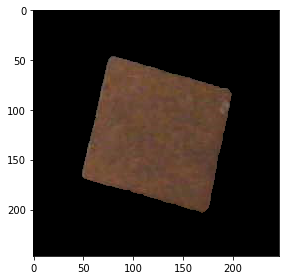

In [ ]:
#added a method call - Feature.imshow() which calls io.imshow,
#on the flushed image.

print(features[2])
features[2].imshow()

##Playground before function implementation

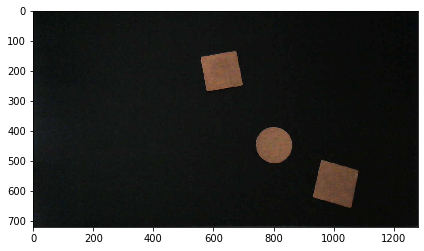

In [ ]:
io.imshow(im)

In [ ]:
#Binarization, using Otsu's thresholding method
thresh = threshold_otsu(gray)
binary = gray > thresh 
io.imshow(binary)

NameError: ignored

In [ ]:
#Salt and pepper noise is to be removed inside the objects
#Use erosion,dilation,opening,closing to remove noise exterior to the objects is necessary

fill_objects = binary.copy()

fill_objects = morphology.binary_erosion(fill_objects)
fill_objects = ndi.binary_fill_holes(fill_objects)
fill_objects = morphology.binary_closing(fill_objects)
fill_objects = morphology.binary_dilation(fill_objects)
io.imshow(fill_objects)

In [ ]:
#labels = measure.label(fill_objects)
labels = measure.label(fill_objects, background = 0)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(fill_objects, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')

In [ ]:
print(labels.max()) #should be equal to the number of objects on the picture

In [ ]:
##PLAY AROUND WITH THIS IF FEATURES CANNOT BE PROPERLY FRAMED!
bound_ratio = 4

#Using connected component labeling tools of skimage
props = measure.regionprops(labels)

centroids = []
perimeters = []
areas = []
orientations = []
euler_numbers = []

#TODO FOR FUNCTION
#Iterate through 1 to len(props)!
##
label_pick = 1
##

centroid = props[label_pick-1].centroid
perimeter = props[label_pick-1].perimeter
area = props[label_pick-1].area
orientation = props[label_pick-1].orientation
euler_number = props[label_pick-1].euler_number #8-neighbors
#euler_number_4 = measure.euler_number(img_labels[label_pick-1], connectivity=4) #4-neighbors
#print(skimage.measure.regionprops.__doc__) #read here for more

compactness = (perimeter**2/area)/(4*np.pi) #defined in class

#Show the specified feature
#find label on label image, put it on the foreground, make the rest of the image the background
#plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral") 

#Get a trimmed off image
feature = np.zeros_like(labels)
feature = np.where((labels==label_pick),labels,0)
trimmed = feature.copy()

#initialize boundaries
bound_top = 0
bound_bot = feature.shape[0]
bound_left = 0
bound_right = feature.shape[1]

"""
#use zero row/cols -- not really a good idea
for row in range(feature.shape[0]):
  bound_top = 0
  if (feature[row,:]==0).all() == True:
    bound_top = row
  else:
    break

for row in range(feature.shape[0]-1,0,-1):
  bound_bot = feature.shape[0]-1
  if (feature[row,:]==0).all() == True:
    bound_bot = row
  else:  
    break

for col in range(feature.shape[1]):
  bound_left = 0
  if (feature[:,col]==0).all() == True:
    bound_left = col
  else:
    break

for col in range(feature.shape[0]-1,0,-1):
  bound_right = feature.shape[0]-1
  if (feature[:,col]==0).all() == True:
    bound_right = col
  else:
    break
#"""
#"""
#use bounded frames derived from centroid position, area, and perimeter data
#quite effective in bounding anything at all - details in the formulation below
bound = (area/perimeter)*bound_ratio
center = tuple([int(centroid[0]),int(centroid[1])])

if center[0]-bound > 0:
  bound_top = int(center[0]-bound)
else:
  bound_top = 0

if center[0]+bound < im.shape[0]:
  bound_bot = int(center[0]+bound)
else:
  bound_bot = im.shape[0]

if center[1]-bound > 0:
  bound_left = int(center[1]-bound)
else:
  bound_left = 0

if center[1]+bound < im.shape[1]:
  bound_right = int(center[1]+bound)
else:
  bound_right = im.shape[1]
#"""
trimmed = feature[bound_top:bound_bot,bound_left:bound_right]
#plt.imshow(trimmed, cmap="nipy_spectral")

im_trimmed = im[bound_top:bound_bot,bound_left:bound_right].copy()
im_flushed = im_trimmed.copy()

im_flushed[:,:,0] = np.where(trimmed==label_pick, im_trimmed[:,:,0], 0)
im_flushed[:,:,1] = np.where(trimmed==label_pick, im_trimmed[:,:,1], 0)
im_flushed[:,:,2] = np.where(trimmed==label_pick, im_trimmed[:,:,2], 0)

feature_color = np.zeros((1,3))

red_flushed = im_flushed[:,:,0]
green_flushed = im_flushed[:,:,1]
blue_flushed = im_flushed[:,:,2]

feature_color[:,0] = red_flushed[red_flushed.nonzero()].mean()
feature_color[:,1] = green_flushed[green_flushed.nonzero()].mean()
feature_color[:,2] = blue_flushed[blue_flushed.nonzero()].mean()

print(f"Feature Number: {label_pick}")
print(f"Averaged RGB values of feature: {feature_color}")
print(f"Centroid: {centroid}")
print(f"Perimeter: {perimeter}")
print(f"Area: {area}")
print(f"Orientation [Radians]: {orientation}")
print(f"Euler Number: {euler_number}") #blobs should yield a one I guess?
print(f"Compactness: {compactness}")
print(f"Top Left Corner: {(bound_top,bound_left)}")
print(f"Bottom Right Corner: {(bound_bot,bound_right)}")

#plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral")
#px.imshow(im)
#plt.imshow(trimmed, cmap="nipy_spectral")
#px.imshow(im_trimmed)
plt.imshow(im_flushed, cmap="nipy_spectral")

In [ ]:
px.imshow(im_flushed)

In [ ]:
#Explanation on why bound = (area/perimeter)*4
#where bound = side/2
#Note: only regular shapes will be used as features in the demo!

side = 10000
bound = side/2

circle_area = 0.25*np.pi*(side**2)
circle_perimeter = np.pi*side
circle_param = circle_area/circle_perimeter

square_area = side**2
square_perimeter = 4*side
square_param = square_area/square_perimeter

triangle_area = 0.4330127*side**2
triangle_perimeter = 3*side
triangle_param = triangle_area/triangle_perimeter

print(circle_param)
print(square_param)
print(triangle_param)

#safe to work with +-triangle_param*3.5~4 from centroid?
print(bound/triangle_param)
print(bound/square_param)

#Singular Value Decomposition to Fit a Singular Vector Between the Centroids

In [ ]:
def PrincipalOrientation(features, debugMode = False):
  """
  A simple function that takes in a cluster of three features from an image to 
  fit a line among their centroids, using Singular Value Decomposition. 
  
  Returns the "axis of principal orientation" that this line is the closest to.
  The principal orientation axes are defined to be the:
    0: horizontal axis
    1: left diagonal axis
    2: vertical axis
    3: right diagonal axis

  Dependencies: Feature class
                import numpy as np

  Inputs: features (list, Feature class) -- A list of 3 features from the image.
          debugMode (bool) -- Toggle to display debug information.

  Outputs: dex -- The index of the nearest principal axis, among 4.
  """
  #Grab the centroid positions from the features
  centroids = np.zeros((len(features),2))
  for idx in range(len(features)):
    centroids[idx][0] = features[idx].centroid[0]
    centroids[idx][1] = features[idx].centroid[1]
  
  #Defining the principal axes. 
  #Since fitted lines won't have a sense of direction,
  #most values will be paired together for the labeling
  principals = [0,45,90,135,180,225,270,315]

  u, s, vt = np.linalg.svd(centroids, full_matrices=True)
  if debugMode == True:
    print(f"U Matrix:\n {u}")
    print(f"Singular Values:\n {s}")
    print(f"VT Matrix:\n {vt}")

  ang=np.abs(np.arctan2(vt[0][0],vt[0][1])*180/np.pi)
  if debugMode == True:
    print(f"Directed angle of best fit line [degrees]: {ang}")
  
  if debugMode == True:
    print(f"Nearest principal axis angle: {principals[(np.abs(principals-ang)).argmin()]}")
  dex = (np.abs(principals-ang)).argmin()
  if dex >= 4:
    dex -= 4
  
  return dex  

##Playground for this function, and testing

In [ ]:
#Playground for the function

dex = PrincipalOrientation(features,debugMode=True)
print(dex)

U Matrix:
 [[-0.40198239  0.91388599  0.0567676 ]
 [-0.56818082 -0.20034225 -0.79814381]
 [-0.71803949 -0.35309402  0.59978655]]
Singular Values:
 [1614.01345208  122.11205444]
VT Matrix:
 [[-0.4643618  -0.88564559]
 [-0.88564559  0.4643618 ]]
Directed angle of best fit line [degrees]: 152.33107331133553
Nearest principal axis angle: 135
3


#Clustering with the KMeans algorithm

In [ ]:
def DistanceEuclidean(features):
  """
  Returns the Euclidean distance among the centroids of
  given two features. Only returns the distance between
  the first two list items.
  
  Input: features (list, Feature class)
  Output: distance_euclidean (float)
  """
  #obtain centroid indices by list comprehension
  c = [f.centroid for f in features]
  #compute Euclidean distance
  distance_euclidean = ((c[0][0]-c[1][0])**2+(c[0][1]-c[1][1])**2)**0.5

  return distance_euclidean

In [ ]:
def FeatureGeoClustering(features_extracted,tolerance=275,n_iterations=3,debugMode=False):
  """
  Dependencies: def distanceEuclidean
                class Feature
                import numpy as np
                from sklearn.cluster import KMeans

  Inputs: features_extracted (list of Feature class instances) - features to be clustered
          tolerance (float) - maximum centroid distance allowed within a cluster
          n_iterations (int) - number of iterations to check centroid distances
          debugMode (bool) - toggle to enable debug information

  Outputs: fcl (list of Feature class instances) - updated features with cluster labels

  Note: There will be a cluster label (label value -1) that is 
  for anything that cannot be clustered for the given conditions.
  This cluster of discarded features will be treated as individual ones.
  Validated clusters of features will have positive label values and can be
  grouped together by calling Feature.cluster
  """

  #Dividing the number of features by three and taking ceiling to generate the  
  #number of maximum possible valid clusters
  n_clusters = np.ceil(len(features_extracted)/3).astype(int)
  if debugMode == True:
    print(f"Expected maximum number of clusters:{n_clusters}")

  kmeans = KMeans(n_clusters = n_clusters).fit([f.centroid for f in features_extracted])

  #Got the first guesses on the clusters, using KMeans!
  for idx in range(len(features_extracted)):
    features_extracted[idx].cluster = kmeans.labels_[idx]
  if debugMode == True:
    print(f"List of initial cluster labels:{[f.cluster for f in features_extracted]}")
  
  #creating shorthand name for convenience
  fcl = features_extracted.copy()

  #Now it is required to "detach" some of these items from the clusters
  #may need to run this multiple times, just like KMeans
  for _ in range(n_iterations):
    
    for i in range(n_clusters):
      #iterate through cluster labels that KMeans printed out

      #store elements of this cluster label in this list
      cls = []
      #go through the feature list to store them in cls
      for f in fcl:
        if f.cluster == i:
          cls.append(f)
      
      #now cleaning up the clustering according to the distances

      #if there are more than 2 elements, check distances
      if len(cls) > 2:
        for j in range(len(cls)): #compare this element with others 

          off_range = True #unless it is proved that they are close, they are not
          
          for k in range(len(cls)): 
            if j!=k: #don't compare it with itself
              dist = DistanceEuclidean([cls[j],cls[k]]) #get Euclidean distance
              if debugMode == True:
                print(f"Comparing: {cls[j].index} with {cls[k].index}. Dist: {dist}")
              if dist < tolerance: 
                off_range = False #if within tolerance, it's not off-range
          
          #if it is off-range, it doesn't belong to this cluster
          if off_range == True:
            #group it with the other discarded items
            cls[j].cluster = -1

          if debugMode == True:
            print(f"Index: {cls[j].index}, off_range: {off_range}")
      
      else: #if less than 3 elements, discard entire cluster proposition
        for elem in cls: 
          elem.cluster = -1

    if debugMode == True:
      print([f.cluster for f in fcl])

  return fcl  


##Playground for testing the clustering algorithm

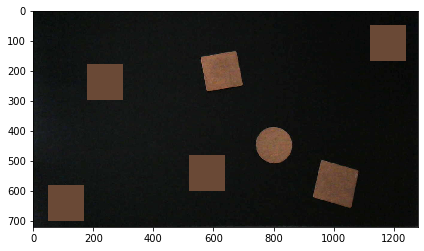

In [ ]:
#Generating a test image for clustering demos

#io.imshow(test_image)
#Using the binary image from the feature extraction playground
#io.imshow(fill_objects)
im_cluster= im.copy()

#Adding in 4 more squares to play with
im_cluster[180:300,180:300] = [106.5400915,73.5848784,54.51492897]
im_cluster[480:600,520:640] = [106.5400915,73.5848784,54.51492897]
im_cluster[50:170,1120:1240] = [106.5400915,73.5848784,54.51492897]
im_cluster[580:700,50:170] = [106.5400915,73.5848784,54.51492897]
io.imshow(im_cluster)

In [ ]:
#get the features for this demo
features_clustering = FeatureExtractor(im_cluster)

Feature Number: 7,
        Averaged RGB values of feature: [[106.  73.  54.]],
        Centroid: (639.5, 109.5),
        Perimeter: 473.65685424949237,
        Area: 14396,
        Orientation [Radians]: 0.7853981633974483,
        Euler Number: 1,
        Compactness: 1.2401549488004056,
        Top Left Corner: (517, 0),
        Bottom Right Corner: (720, 230),
        Cluster: -1,
        Assigned Effect #ID: None,
        Feature Vector: None
[-1, -1, -1, 2, 2, 2, -1]


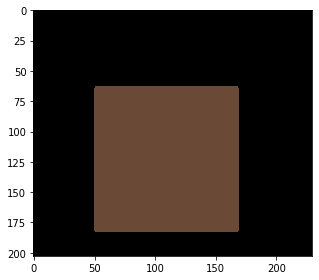

In [ ]:
#GeoClustering demo
features_clustered = FeatureGeoClustering(features_clustering)
idx = 6
print(features_clustered[idx])
features_clustered[idx].imshow()
print([f.cluster for f in features_clustered])

###Some more playing around for debugging and testing

In [ ]:
#Dividing the number of features by three and taking ceiling to generate the  
#number of maximum possible valid clusters
n_clusters = np.ceil(len(features_clustering)/3).astype(int)
print(n_clusters)
print(type(n_clusters))

In [ ]:
#Now taking the centroid positions to cluster them
centroids_clustering = [f.centroid for f in features_clustering]
print(centroids_clustering)

In [ ]:
kmeans = KMeans(n_clusters = n_clusters).fit([f.centroid for f in features_clustering])

In [ ]:
kmeans.labels_

In [ ]:
#There are three clusters as designated,
#One cluster has an extra square, that we want to get rid of
#That square is the topmost "original" square at idx = 1
#Other clusters are worthless, so we gather them together later as well
idx = 1

print(features_clustering[idx])
features_clustering[idx].imshow()

##Passing Clusters into Data Analysis Functions

In [ ]:
def FeatureLineFitting(features_clustered,debugMode=False):
  """
  A function to pass feature lists with clustering information, to obtain
  the closest diagonal, horizontal or vertical line that passes nearest to the
  best fit lines of each cluster.

  This function must be called after using GeoClustering.

  Inputs: features_clustered (list of Feature class instances)
  Outputs: features_analyzed (list of Feature class instances)
  """

  #copying over the clustered features list
  features_analyzed = features_clustered.copy()

  #the end condition for the for loop:
  n_cluster_iter = max([f.cluster for f in features_clustered])+1

  for i in range(n_cluster_iter):
    #pick all cluster elements of the given positive index
    cluster_elems = [f for f in features_analyzed if f.cluster == i]
    #use data analysis to fit a line, and select closest line representing 
    #the effect_id of this "chord"
    effect_id = PrincipalOrientation(cluster_elems,debugMode=debugMode)
    #assign this effect_id to all elements
    for elem in cluster_elems:
      elem.effect_id = effect_id
  
    if debugMode == True:
      print(f"Clusters that were assigned: {[f.cluster for f in features_analyzed]}")
      print(f"Effect #ID's that are assigned: {[f.effect_id for f in features_analyzed]}")
      #features_analyzed[i].imshow() #don't want to flood the screen with images
    
  return features_analyzed

###Testing the function

In [ ]:
features_analyzed = LineFittingClusters(features_clustered)

In [ ]:
print(f"Clusters that were assigned: {[f.cluster for f in features_analyzed]}")
print(f"Effect #ID's that are assigned: {[f.effect_id for f in features_analyzed]}")